In [1]:
import networkx as nx
from src.qaoa import *
import matplotlib.pyplot as plt
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit
from IPython.display import display, SVG

In [2]:
# Example graph
graph = nx.erdos_renyi_graph(4, 0.5)  # A small example graph

# Example parameters
p = 1
gamma = [np.pi / 4] * p
beta = [np.pi / 4] * p

# Create the QAOA circuit
circuit = create_qaoa_circuit(graph, p, gamma, beta)

# Print the text-based diagram
print(circuit)

0: ───H───ZZ───────────ZZ───────────X^(11/14)────────────────M('result')───
          │            │                                     │
1: ───H───ZZ^(11/14)───┼────────────ZZ───────────X^(11/14)───M─────────────
                       │            │                        │
2: ───H───X^(11/14)────┼────────────┼────────────────────────M─────────────
                       │            │                        │
3: ───H────────────────ZZ^(11/14)───ZZ^(11/14)───X^(11/14)───M─────────────


In [ ]:
# Draw the circuit using SVG and display it in Jupyter
svg_circuit = SVGCircuit(circuit)
display(SVG(svg_circuit.to_svg()))


In [14]:
from utils import *

# read random graphs from path
src_dir = "./data/graphs-10nodes_100elems.pkl"
random_graphs = load_pickle(src_dir)

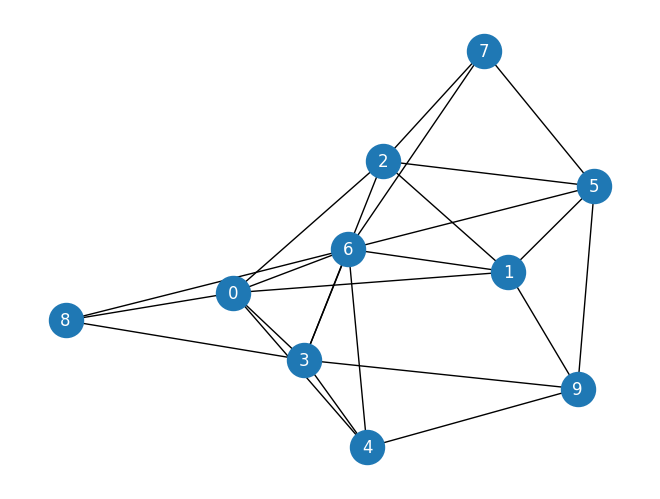

In [16]:
show_graph(random_graphs[0])

In [2]:
import cirq
import numpy as np
import scipy.optimize
from utils import *

# read random graphs from path
src_dir = "./data/graphs-10nodes_100elems.pkl"
random_graphs = load_pickle(src_dir)


# Define QAOA circuit
def maxcut_cost_operator(graph: nx.Graph, gamma: float):
    cost_ops = []
    for u, v in graph.edges:
        qubit_u = cirq.LineQubit(u)
        qubit_v = cirq.LineQubit(v)
        cost_ops.append(cirq.ZZ(qubit_u, qubit_v) ** gamma)
    return cost_ops

def mixing_operator(graph: nx.Graph, beta: float):
    mix_ops = []
    for node in graph.nodes:
        qubit = cirq.LineQubit(node)
        mix_ops.append(cirq.X(qubit) ** beta)
    return mix_ops

def create_qaoa_circuit(graph: nx.Graph, p: int, gamma: List[float], beta: List[float]) -> cirq.Circuit:
    qubits = cirq.LineQubit.range(len(graph.nodes))
    circuit = cirq.Circuit()
    
    # Initialize in superposition
    circuit.append(cirq.H.on_each(qubits))
    
    for i in range(p):
        circuit.append(maxcut_cost_operator(graph, gamma[i]))
        circuit.append(mixing_operator(graph, beta[i]))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    
    return circuit

# Optimize QAOA parameters
def objective_function(params, graph, p):
    gamma = params[:p]
    beta = params[p:]
    circuit = create_qaoa_circuit(graph, p, gamma, beta)
    
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)
    measurements = result.measurements['result']
    
    maxcut_value = 0
    for bitstring in measurements:
        cut_value = sum(1 for edge in graph.edges if bitstring[edge[0]] != bitstring[edge[1]])
        maxcut_value += cut_value
    
    return -maxcut_value / 1000

def optimize_qaoa(graph: nx.Graph, p: int):
    initial_params = np.random.uniform(0, np.pi, 2 * p)
    result = scipy.optimize.minimize(objective_function, initial_params, args=(graph, p), method='Nelder-Mead')
    return result.x

# Run optimization for each graph
p = 1  # Number of layers in QAOA, adjust as needed
optimized_parameters = []

for i, graph in enumerate(random_graphs):
    print(f"Optimizing QAOA for graph {i + 1}/{num_graphs}")
    optimal_params = optimize_qaoa(graph, p)
    optimized_parameters.append(optimal_params)
    print(f"Optimal parameters for graph {i + 1}: {optimal_params}")

# Evaluate the performance on all graphs (optional)
# This can include calculating the average cut value, comparing to classical algorithms, etc.


Optimizing QAOA for graph 1/100
Optimal parameters for graph 1: [1.13439591 2.23235604]
Optimizing QAOA for graph 2/100
Optimal parameters for graph 2: [0.43315617 0.56470046]
Optimizing QAOA for graph 3/100
Optimal parameters for graph 3: [0.1771283  1.80203442]
Optimizing QAOA for graph 4/100
Optimal parameters for graph 4: [0.83493366 1.25331409]
Optimizing QAOA for graph 5/100
Optimal parameters for graph 5: [1.15960562 1.70341263]
Optimizing QAOA for graph 6/100
Optimal parameters for graph 6: [0.15132793 1.78059323]
Optimizing QAOA for graph 7/100
Optimal parameters for graph 7: [1.34036371 1.07900146]
Optimizing QAOA for graph 8/100
Optimal parameters for graph 8: [1.83820518 2.21346332]
Optimizing QAOA for graph 9/100
Optimal parameters for graph 9: [0.8761272 2.7729529]
Optimizing QAOA for graph 10/100
Optimal parameters for graph 10: [0.13659882 0.78193101]
Optimizing QAOA for graph 11/100
Optimal parameters for graph 11: [1.37917677 0.24756489]
Optimizing QAOA for graph 12/1

In [6]:
import pickle

In [11]:
dst_graphs = "./graphs_list.pkl"
dst_params = "./p1_qc_opt_params.pkl"

In [12]:
with open(dst_graphs, 'wb') as file:
    pickle.dump(random_graphs, file, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open(dst_params, 'wb') as file:
    pickle.dump(optimized_parameters, file, protocol=pickle.HIGHEST_PROTOCOL)

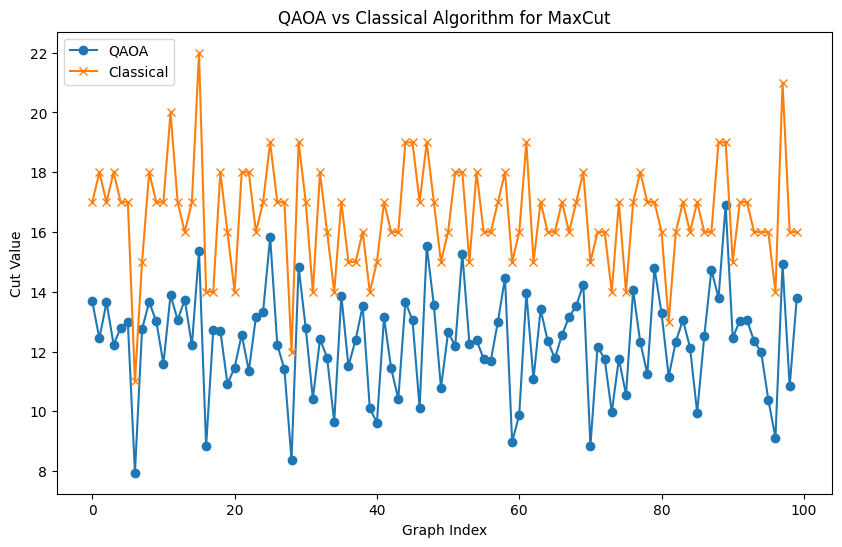

In [10]:
import matplotlib.pyplot as plt

def evaluate_qaoa(graph, p, gamma, beta):
    circuit = create_qaoa_circuit(graph, p, gamma, beta)
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)
    measurements = result.measurements['result']
    
    maxcut_value = 0
    for bitstring in measurements:
        cut_value = sum(1 for edge in graph.edges if bitstring[edge[0]] != bitstring[edge[1]])
        maxcut_value += cut_value
    
    average_cut_value = maxcut_value / 1000
    return average_cut_value

def compare_qaoa_with_classical(graphs, optimized_parameters, classical_algorithm):
    qaoa_cut_values = []
    classical_cut_values = []
    
    for i, graph in enumerate(graphs):
        gamma, beta = optimized_parameters[i][:p], optimized_parameters[i][p:]
        qaoa_cut_value = evaluate_qaoa(graph, p, gamma, beta)
        qaoa_cut_values.append(qaoa_cut_value)
        
        classical_cut_value = classical_algorithm(graph)
        classical_cut_values.append(classical_cut_value)
    
    return qaoa_cut_values, classical_cut_values

def plot_results(qaoa_cut_values, classical_cut_values):
    plt.figure(figsize=(10, 6))
    plt.plot(qaoa_cut_values, label='QAOA', marker='o')
    plt.plot(classical_cut_values, label='Classical', marker='x')
    plt.xlabel('Graph Index')
    plt.ylabel('Cut Value')
    plt.title('QAOA vs Classical Algorithm for MaxCut')
    plt.legend()
    plt.show()

# Example classical algorithm (Goemans-Williamson algorithm)
def classical_algorithm(graph):
    # Implement or use a library to solve MaxCut classically (e.g., NetworkX approximation)
    cut_value, partition = nx.algorithms.approximation.maxcut.one_exchange(graph)
    return cut_value

# Compare QAOA with classical algorithm
qaoa_cut_values, classical_cut_values = compare_qaoa_with_classical(random_graphs, optimized_parameters, classical_algorithm)

# Plot the results
plot_results(qaoa_cut_values, classical_cut_values)


In [1]:
import cirq
import numpy as np
import networkx as nx
import scipy.optimize
from typing import List

In [2]:
# Generate random graphs
def generate_random_graphs(num_graphs: int, num_nodes: int, edge_prob: float) -> List[nx.Graph]:
    graphs = [nx.erdos_renyi_graph(num_nodes, edge_prob) for _ in range(num_graphs)]
    return graphs

In [11]:
num_graphs = 100
num_nodes = 10 
edge_prob = 0.5  
random_graphs = generate_random_graphs(num_graphs, num_nodes, edge_prob)

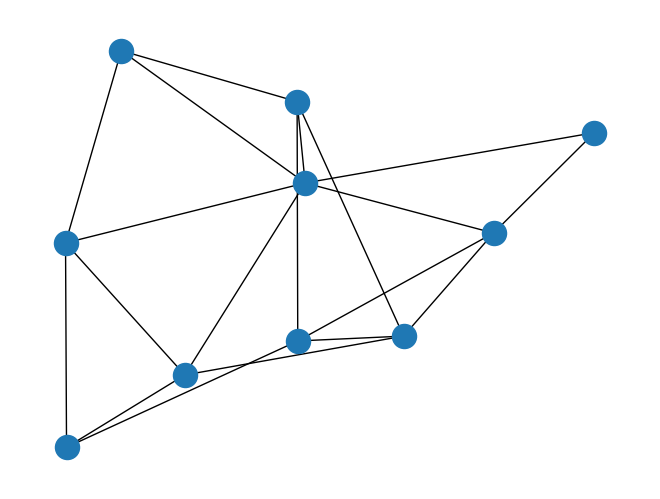

In [35]:
nx.draw(random_graphs[0])

In [36]:
def maxcut_cost_operator(graph: nx.Graph, gamma: float):
    cost_ops = []
    for u, v in graph.edges:
        qubit_u = cirq.LineQubit(u)
        qubit_v = cirq.LineQubit(v)
        cost_ops.append(cirq.Z(qubit_u) * cirq.Z(qubit_v))
    return cirq.PauliSum(cost_ops).with_coefficient(-gamma)

def mixing_operator(graph: nx.Graph, beta: float):
    mix_ops = []
    for node in graph.nodes:
        qubit = cirq.LineQubit(node)
        mix_ops.append(cirq.X(qubit))
    return cirq.PauliSum(mix_ops).with_coefficient(-beta)

def create_qaoa_circuit(graph: nx.Graph, p: int, gamma: List[float], beta: List[float]) -> cirq.Circuit:
    qubits = cirq.LineQubit.range(len(graph.nodes))
    circuit = cirq.Circuit()
    
    # Initialize in superposition
    circuit.append(cirq.H.on_each(qubits))
    
    for i in range(p):
        circuit.append(maxcut_cost_operator(graph, gamma[i]).to_gate())
        circuit.append(mixing_operator(graph, beta[i]).to_gate())
    
    return circuit


In [37]:
def objective_function(params, graph, p):
    gamma = params[:p]
    beta = params[p:]
    circuit = create_qaoa_circuit(graph, p, gamma, beta)
    
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)
    measurements = np.array(result.measurements.values()).T
    
    maxcut_value = 0
    for bitstring in measurements:
        cut_value = sum(graph.edges[edge]['weight'] if bitstring[edge[0]] != bitstring[edge[1]] else 0 for edge in graph.edges)
        maxcut_value += cut_value
    
    return -maxcut_value / 1000

def optimize_qaoa(graph: nx.Graph, p: int):
    initial_params = np.random.uniform(0, np.pi, 2 * p)
    result = scipy.optimize.minimize(objective_function, initial_params, args=(graph, p), method='Nelder-Mead')
    return result.x


In [38]:
p = 1  # Number of layers in QAOA, adjust as needed
optimized_parameters = []

for i, graph in enumerate(random_graphs):
    print(f"Optimizing QAOA for graph {i + 1}/{num_graphs}")
    optimal_params = optimize_qaoa(graph, p)
    optimized_parameters.append(optimal_params)
    print(f"Optimal parameters for graph {i + 1}: {optimal_params}")

# Evaluate the performance on all graphs (optional)
# This can include calculating the average cut value, comparing to classical algorithms, etc.

Optimizing QAOA for graph 1/100


ValueError: PauliSum constructor takes a LinearDict[UnitPauliStringT]. Consider using PauliSum.from_pauli_strings() or adding and subtracting PauliStrings